---
# SUMMER SCHOOL 2022:
## Text mining and Natural Language Processing for Computational Social Sciences

### SocialComQuant Project - Online Teaching Module: Text Representation Learning

### André Panisson

---


In [1]:
import numpy as np
from matplotlib import pyplot as plt

# 1. Traditional Approaches to Text Classification

In this notebook, we're going to experiment with a few "traditional" approaches to text classification. These approaches pre-date the deep learning revolution in Natural Language Processing, but are often quick and effective ways of training a text classifier.

## 1.1 The Dataset: IMDB

IMDB Dataset is a large dataset of movie reviews collected from the Internet Movie DataBase.

It is very useful for training text classification models for sentiment analysis. It contains 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.

Main reference: http://ai.stanford.edu/~amaas/data/sentiment/

We will use the `dataset` package from 🤗 (https://HuggingFace.co) to download and use the data.

We will limit both training and test sets to a smaller subset, so we can run this exercise in less time.

If you want, you can remove these limits and check later the results with a bigger dataset.

In [2]:
from datasets import load_dataset

imdb = load_dataset("imdb", split="train")
imdb = imdb.train_test_split(train_size=5000, test_size=5000, seed=42)

Reusing dataset imdb (/home/panisson/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
Loading cached split indices for dataset at /home/panisson/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-cc7bf445f84ad2a1.arrow and /home/panisson/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-6987fd269768b1cf.arrow


In [3]:
train_documents = imdb["train"]['text']
train_target = imdb["train"]['label']

test_documents = imdb["test"]['text']
test_target = imdb["test"]['label']

In [4]:
train_documents[10]

'<br /><br />How this film ever got a 6 star average is beyond me. The script is so banal, and frankly an insult to whomevers life it is based upon. The cinematography comes straight from the slick world of advertising, and the talented Ridley Scott should be ashamed. Demi Moore however, shows none a surprise by participating in this film, if one looks at her tracklist. All in all, a "high concept" style film that even Don Simpson would be ashamed of.'

In [5]:
train_target[10]

0

In [6]:
from collections import Counter
Counter(train_target)

Counter({1: 2490, 0: 2510})

## 1.2 Preprocessing

The first step in the development of any NLP model is text preprocessing. This means we're going to transform our texts from word sequences to feature vectors. These feature vectors contain their values for each of a large number of features.

### The BoW (Bag of Words) approach
In this experiment, we're going to work with so-called "bag-of-word" approaches. Bag-of-word methods treat every text as an unordered collection of words (or optionally, ngrams), and the raw feature vectors simply tell us how often each word (or ngram) occurs in a text. In Scikit-learn, we can construct these raw feature vectors with the CountVectorizer, which tokenizes a text and counts the number of times any given text contains every token in the corpus.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score

In [8]:
cv = CountVectorizer()
C = cv.fit_transform(train_documents)
feature_names = cv.get_feature_names_out()

In [9]:
print(sorted([(feature_names[i], C[10,i]) for i in C[10].nonzero()[1]], key=lambda x: -x[1]))

[('the', 4), ('film', 3), ('is', 3), ('and', 2), ('of', 2), ('br', 2), ('all', 2), ('this', 2), ('in', 2), ('be', 2), ('ashamed', 2), ('it', 1), ('to', 1), ('at', 1), ('one', 1), ('that', 1), ('script', 1), ('an', 1), ('life', 1), ('if', 1), ('would', 1), ('me', 1), ('so', 1), ('got', 1), ('comes', 1), ('from', 1), ('ever', 1), ('however', 1), ('her', 1), ('how', 1), ('world', 1), ('by', 1), ('talented', 1), ('upon', 1), ('participating', 1), ('even', 1), ('don', 1), ('star', 1), ('average', 1), ('beyond', 1), ('banal', 1), ('frankly', 1), ('insult', 1), ('whomevers', 1), ('based', 1), ('cinematography', 1), ('straight', 1), ('slick', 1), ('advertising', 1), ('ridley', 1), ('scott', 1), ('should', 1), ('demi', 1), ('moore', 1), ('shows', 1), ('none', 1), ('surprise', 1), ('looks', 1), ('tracklist', 1), ('high', 1), ('concept', 1), ('style', 1), ('simpson', 1)]


### TF-IDF weighting

The above raw counts are not very informative yet. This is because the raw feature vectors of most texts in the same language will be very similar. For example, most texts in English contain many instances of relatively uninformative words, such as a, the or be. Instead, what we're interested in are words like _amazing_ or _terrible_: words that occur often in one text, but not very often in the corpus as a whole. Therefore we're going to weight all features by their tf-idf score, which counts the number of times every token appears in a text and divides it by (the logarithm of) the percentage of corpus documents that contain that token.

**Term Frequency(TF)** – The number of occurrences of a word in a document divided by a total number of terms in a document is referred to as Term Frequency. For example, I have to find the Term frequency of _terrible_ in the below sentence then it will be 1/4. It says how frequently a particular word occurs in a particular document.
```
This movie is terrible.
```

**Inverse Document Frequency** – Total number of documents in corpus divided by the total number of documents with term T in them and taking the log of a complete fraction is inverse document frequency. If we have a word that comes in all documents then the resultant output of the log is zero. The Scikit-learn implementation uses a little bit different implementation because if it becomes zero then the contribution of the word is ignored so they add one in the resultant and because of which you can observe the values of TFIDF a bit high. If a word comes only a single time then IDF will be higher.

This weighting is performed by Scikit-learn's TfidfTransformer.

In [10]:
tfidf = TfidfTransformer()
X = tfidf.fit_transform(C)

print(sorted([(feature_names[i], round(X[10,i], 2)) for i in X[10].nonzero()[1]], key=lambda x: -x[1]))

[('ashamed', 0.34), ('whomevers', 0.24), ('tracklist', 0.24), ('demi', 0.22), ('ridley', 0.21), ('participating', 0.2), ('advertising', 0.2), ('simpson', 0.19), ('banal', 0.19), ('slick', 0.18), ('moore', 0.17), ('insult', 0.16), ('scott', 0.15), ('frankly', 0.15), ('concept', 0.14), ('upon', 0.13), ('talented', 0.13), ('surprise', 0.13), ('straight', 0.13), ('film', 0.13), ('average', 0.13), ('none', 0.12), ('cinematography', 0.12), ('beyond', 0.12), ('the', 0.11), ('style', 0.11), ('star', 0.11), ('based', 0.11), ('shows', 0.1), ('looks', 0.1), ('high', 0.1), ('comes', 0.1), ('world', 0.09), ('script', 0.09), ('is', 0.09), ('however', 0.09), ('got', 0.09), ('br', 0.09), ('be', 0.09), ('all', 0.09), ('should', 0.08), ('life', 0.08), ('how', 0.07), ('her', 0.07), ('ever', 0.07), ('would', 0.06), ('this', 0.06), ('of', 0.06), ('me', 0.06), ('in', 0.06), ('even', 0.06), ('don', 0.06), ('and', 0.06), ('so', 0.05), ('if', 0.05), ('from', 0.05), ('by', 0.05), ('at', 0.05), ('an', 0.05), ('o

## 1.3 Training
Next, we train a text classifier on the preprocessed training data. We're going to experiment with a classic text classification model: Logistic Regression.

[Logistic Regression models](https://en.wikipedia.org/wiki/Logistic_regression) model the log-odds $l$, or $log(p/(1-p))$, of a class as a linear model and estimate the parameters $\beta$ of the model during training: 

\begin{equation*}
l = \beta_0 + \sum_{i=1}^n \beta_i x_i
\end{equation*}

These models often achieve great performance in text classification.

### Model selection

It also might be appropriate to add regularization to a Logistic Regression model, to avoid overfitting.
In Scikit-Learn, we can add a regularization of type L2 through the parameter `C`. This means the function we are optimizing is a bit different:

\begin{equation*}
l = \beta_0 + \sum_{i=1}^n \beta_i x_i + \frac{1}{C}\sum_{i=1}^n \beta_i^2
\end{equation*}

In [11]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=200)

Cs = [0.1, 1, 5]
for C in Cs:
    model.C = C
    scores = cross_val_score(model, X, train_target)
    print(f"Model performance achieved an accuracy of {scores.mean():.4f} with C={C}.")

Model performance achieved an accuracy of 0.8038 with C=0.1.
Model performance achieved an accuracy of 0.8492 with C=1.
Model performance achieved an accuracy of 0.8612 with C=5.


In [12]:
model = LogisticRegression(C=5, max_iter=200)
model.fit(X, train_target);

## 1.4 Testing

In [13]:
C_test = cv.transform(test_documents)
X_test = tfidf.transform(C_test)

In [14]:
true_labels = test_target
pred_labels = model.predict(X_test)

In [15]:
cm = confusion_matrix(true_labels, pred_labels)
print(cm)

[[2184  310]
 [ 284 2222]]


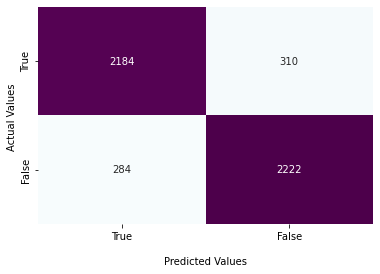

In [16]:
import seaborn as sns
ax = sns.heatmap(cm, annot=True, cmap='BuPu', fmt='g', cbar=False)
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['True','False'])
ax.yaxis.set_ticklabels(['True','False']);

In [17]:
print(accuracy_score(true_labels, pred_labels))

0.8812
